# Subjectivity analysis
Use [subjective/objective movie review data](https://www.cs.cornell.edu/people/pabo/movie-review-data/) to train a classifier to filter out objective sentences as a preprocessing step to sentiment analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
import spacy
# nlp = spacy.load("en_core_web_sm", exclude=["ner"]) # use lg-model in final evaluation
nlp = spacy.load("en_core_web_lg", exclude=["ner"])

In [99]:
!pip show spacy | grep Version

Version: 3.2.0


## Load the subjectivity dataset
The data of reviews are assumed to be subjective, and the plot descriptions are assumed to be objective.

In [4]:
objective_df = pd.read_csv('subjectivity_data/plot.tok.gt9.5000', encoding='ISO-8859-1', # alternatively, 'latin-1'
                            sep='\n', header=None, names=['sentence'])
subjective_df  = pd.read_csv('subjectivity_data/quote.tok.gt9.5000', encoding='ISO-8859-1', # alternatively, 'latin-1'
                            sep='\n', header=None, names=['sentence'])
subjective_df['label'] = 1
objective_df['label'] = 0

data = pd.concat([objective_df, subjective_df], ignore_index=False)
data.head()

,sentence,label
0,the movie begins in the past where a young boy...,0
1,emerging from the human psyche and showing cha...,0
2,spurning her mother's insistence that she get ...,0
3,amitabh can't believe the board of directors a...,0
4,"she , among others excentricities , talks to a...",0


Split the data into training (70%) and test (30%) sets.

In [5]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(data.sentence, data.label,
                                                                              test_size=0.3, random_state=100)

train_sentences.head()

1191    never giving up the fight to win the war , mcn...
4458    the plan goes by smoothly , but troubles comes...
1131    ultimately , anime moves far beyond the realm ...
4562     in the end , white oleander isn't an adaptati...
1579    this story of a determined woman's courage to ...
Name: sentence, dtype: object

Perhaps stop words should not be checked since they provide information on negation/modification of other words, and there are domain specific words. Should non-alphanumeric characters be removed here as well?

In [6]:
def doc_preprocessor_no_sw(text):
    """
    Preprocessor that returns a list of lemmas of a given text,
    with stop words filtered out.
    
    Args:
        - text: string that contains the text to be preprocessed
        
    Returns:
        - tokens: a list of strings (lemmas)
    """
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return tokens

def doc_preprocessor(text):
    """
    Preprocessor that returns a list of lemmas of a given text.
    
    Args:
        - text: string that contains the text to be preprocessed
        
    Returns:
        - tokens: a list of strings (lemmas)
    """
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    #tokens = [token.text for token in doc]
    return tokens

In [7]:
print(' '.join(doc_preprocessor(train_sentences.iloc[4])))
print(train_sentences.iloc[4])

this story of a determined woman 's courage to find her husband in a war zone offer win performance and some effect moment .
this story of a determined woman's courage to find her husband in a war zone offers winning performances and some effecting moments . 


Use count/binary vectorizer. Don't use stop words here either.

In [ ]:
subj_n_grams = (1, 1) # unigram
subj_binary_counts_ = False
subj_stop_words_ = None

# SET doc_preprocessor AS THE tokenizer ATTRIBUTE IN THE COUNT VECTORIZER TO USE IT
bin_vectorizer = CountVectorizer(strip_accents=None, lowercase=True,
                                 preprocessor=None, tokenizer=doc_preprocessor,
                                 stop_words=subj_stop_words_, ngram_range=subj_n_grams,
                                 binary=subj_binary_counts_)

bin_vectorizer.fit(train_sentences)

train_vec = bin_vectorizer.transform(train_sentences)
test_vec  = bin_vectorizer.transform(test_sentences)

## Train a naïve Bayes classifier (subjectivity)
Predict on the test set

In [10]:
m_naive_bayes = MultinomialNB()
m_naive_bayes.fit(train_vec, train_labels)
te_pred = m_naive_bayes.predict(test_vec)

for i in range(4):
    print(f'true: {test_labels.values[i]}, predicted: {te_pred[i]}\n\'{test_sentences.values[i]}\'\n')

true: 1, predicted: 0
' " the emperor's new clothes " begins with a simple plan . . . . well , at least that's the plan . '

true: 1, predicted: 1
'it throws quirky characters , odd situations , and off-kilter dialogue at us , all as if to say , " look at this ! this is an interesting movie ! " but the film itself is ultimately quite unengaging . '

true: 0, predicted: 0
'three fraternal bank robbers languishing in jail , discover a profitable ( if not dodgy ) way to spend their time . '

true: 0, predicted: 0
'it seems like a perfect opportunity for kilo to get back to his family , but this job leads to a world of trouble for kilo after his release . '

true: 0, predicted: 0
'the don's legal will , which also includes diamonds worth hundred crores kept in a foreign bank , has to be equally divided between these three and to claim the diamonds from the bank all three all three have to be present at the bank and personally sign the papers . '

true: 0, predicted: 0
'along the way , he m

In [11]:
con_mat = classification_report(test_labels, te_pred, target_names=['objective', 'subjective'])
print(con_mat)

              precision    recall  f1-score   support

   objective       0.94      0.89      0.92      1495
  subjective       0.90      0.94      0.92      1505

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



### Train the subjectivity classifier on all data

In [ ]:
subj_lab = data.label
subj_vec = bin_vectorizer.transform(data.sentence)
subj_classifier = MultinomialNB()
subj_classifier.fit(subj_vec, subj_lab)
subj_pred = m_naive_bayes.predict(subj_vec)

In [13]:
con_mat_sb = classification_report(subj_lab, subj_pred, target_names=['objective', 'subjective'])
print(con_mat_sb)

              precision    recall  f1-score   support

   objective       0.97      0.93      0.95      5000
  subjective       0.93      0.97      0.95      5000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



# Graph-based subjectivity classification
Method adopted from [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts by Pang and Lee](https://arxiv.org/abs/cs/0409058). Use proximity information to decide if a sentence should be classified as subjective or objective. Use the naïve Bayes classifier probabilities as weights in a graph and find the minimum cut to separate objective from subjective sentences.

The weights from the source to a sentence is the probability of the sentence being objective (1), and from a sentence to the sink the weight is the probability of the sentence being subjective (0).

Use the package `networkx` for running the min-cut algorithm [`networkx.algorithms.flow.minimum_cut`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.minimum_cut.html).

In [14]:
import networkx as nx
from networkx.algorithms.flow import minimum_cut

Use an associative weight between sentence nodes $assoc(s_i,s_j) = c\cdot f(j-i) $ for $j-1 \leq T$ and $0$ otherwise, where $f(d)$ is decreasing. Pang and Lee used $c\in[0,1]$ with steps of $0.1$, $T\in\{1,2,3\}$, and $f(d)\in\{1, e^{1-d}, 1/d^2\}$, giving $11\cdot 3\cdot 3=99$ parameter combinations.

In [15]:
def get_assoc_matrix(n_sentences, threshold=3, c=0.5):
    """
    Returns the weight matrix for the nodes
    
    Args:
        - n_sentences: the number of sentences in the review
        - threshold: the number of sentences that count as being close
        - c: weight (for each class) of the associative function
    """
    A = np.zeros((n_sentences,n_sentences))
    
    for i in range(n_sentences):
        for j in range(i+1, n_sentences):
            if j-i <= threshold:
                d = j-i
                A[i,j] = c*np.exp(1-d)
                A[j,i] = c*np.exp(1-d)
    return A


def get_graph_matrix(n_sentences, obj_prob, subj_prob, threshold=3, c=0.5):
    """
    Produces the (undirected) adjacency matrix for the proposed
    minimum cut problem.
    
    Args:
        - n_sentences: number of sentences in the review
        - obj_prob: probabilities that the sentence is classified as objective
        - subj_prob: probabilities that the sentence is classified as subjective
        
        Arguments used in the association matrix computation:
        - threshold: the number of sentences that count as being close
        - c: weight (for each class) of the associative function
        
    Returns:
        - M: numpy array that represents the graph
    """
    
    A = get_assoc_matrix(n_sentences, threshold, c)
    
    M = np.zeros((n_sentences+2, n_sentences+2))
    M[1:n_sentences+1, 0] = obj_prob[0:n_sentences]
    M[0, 1:n_sentences+1] = obj_prob[0:n_sentences]

    M[n_sentences+1, 1:n_sentences+1] = subj_prob[0:n_sentences]
    M[1:n_sentences+1, n_sentences+1] = subj_prob[0:n_sentences]

    M[1:n_sentences+1, 1:n_sentences+1] = A
    
    return M

In [16]:
prob = m_naive_bayes.predict_proba(test_vec)
to_source = prob[:,0] # objective probability
to_sink = prob[:,1]   # subjective probability

print(prob)
print(te_pred)

[[9.90467589e-01 9.53241109e-03]
 [1.01389576e-10 1.00000000e+00]
 [9.99999925e-01 7.49300802e-08]
 ...
 [9.99999994e-01 5.64076065e-09]
 [9.98116132e-01 1.88386790e-03]
 [9.99508058e-01 4.91942391e-04]]
[0 1 0 ... 0 0 0]


__N.B. In the example below we use sentences that are _not_ close to each other, and the classification will _not_ be improved here as a result.__

In [17]:
n_sentences = 8
M = get_graph_matrix(n_sentences, to_source, to_sink)
print(np.around(M,3))

[[0.    0.99  0.    1.    1.    1.    1.    1.    1.    0.   ]
 [0.99  0.    0.5   0.184 0.068 0.    0.    0.    0.    0.01 ]
 [0.    0.5   0.    0.5   0.184 0.068 0.    0.    0.    1.   ]
 [1.    0.184 0.5   0.    0.5   0.184 0.068 0.    0.    0.   ]
 [1.    0.068 0.184 0.5   0.    0.5   0.184 0.068 0.    0.   ]
 [1.    0.    0.068 0.184 0.5   0.    0.5   0.184 0.068 0.   ]
 [1.    0.    0.    0.068 0.184 0.5   0.    0.5   0.184 0.   ]
 [1.    0.    0.    0.    0.068 0.184 0.5   0.    0.5   0.   ]
 [1.    0.    0.    0.    0.    0.068 0.184 0.5   0.    0.   ]
 [0.    0.01  1.    0.    0.    0.    0.    0.    0.    0.   ]]


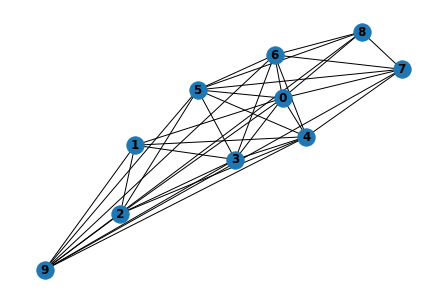

In [18]:
G = nx.convert_matrix.from_numpy_matrix(M)
nx.draw(G, with_labels=True, font_weight='bold')

In [19]:
cut_value, partition = minimum_cut(flowG = G, _s=0, _t=n_sentences+1, capacity='weight')

In [20]:
subjective_sent = np.zeros(n_sentences)
for n in partition[1]:
    if not n==n_sentences+1:
        subjective_sent[n] = 1

In [21]:
print(partition)
for i in range(8):
    print(f'true: {test_labels.values[i]}, nb: {te_pred[i]}, min-cut: {int(subjective_sent[i])}\n{test_sentences.values[i]}')

({0, 1, 2, 3, 4, 5, 6, 7, 8}, {9})
true: 1, nb: 0, min-cut: 0
 " the emperor's new clothes " begins with a simple plan . . . . well , at least that's the plan . 
true: 1, nb: 1, min-cut: 0
it throws quirky characters , odd situations , and off-kilter dialogue at us , all as if to say , " look at this ! this is an interesting movie ! " but the film itself is ultimately quite unengaging . 
true: 0, nb: 0, min-cut: 0
three fraternal bank robbers languishing in jail , discover a profitable ( if not dodgy ) way to spend their time . 
true: 0, nb: 0, min-cut: 0
it seems like a perfect opportunity for kilo to get back to his family , but this job leads to a world of trouble for kilo after his release . 
true: 0, nb: 0, min-cut: 0
the don's legal will , which also includes diamonds worth hundred crores kept in a foreign bank , has to be equally divided between these three and to claim the diamonds from the bank all three all three have to be present at the bank and personally sign the papers .

Sanity check: We disregard the sink and source nodes 0 and 9. The set of nodes that are grouped with node 0 are objective, and the set of nodes that are grouped with node 1 are subjective. In this case the split is not correct for the NB classifier, and the min-cut classifier in addition (wrongly) decides that the second sentence is objective. If the emphasis on proximity is increased (e.g. increase $c$ or $T$), the partition might change. *The min-cut classifier cannot be evaluated on the subjectivity dataset since there are no reviews of more than one sentence. However, it can be evaluated as a preprocessing tool on the downstream task of sentiment classification.*

# Classification of reviews
## Read reviews
After using the loading functions below, the data can be persisted for quicker loading.

### Dataset 1: IMDb dataset
Below is a function to read and put together the [IMDb dataset](https://ai.stanford.edu/~amaas/data/sentiment/) (collected by Maas et al.) into a dataframe.

In [22]:
def read_folder(folder_path):
    file_paths = os.listdir(folder_path)
    review = []
    for filename in file_paths:
        with open(f'{folder_path}/{filename}', mode='r', encoding="utf8") as file:
            review.append(file.readline())
    return review, file_paths


def load_imdb_data():
    tr_pos_review, _ = read_folder('aclImdb/train/pos')
    tr_neg_review, _ = read_folder('aclImdb/train/neg')
    te_pos_review, _ = read_folder('aclImdb/test/pos')
    te_neg_review, _ = read_folder('aclImdb/test/neg')
    
    tr_reviews_pos = pd.DataFrame(tr_pos_review, columns=['review'])
    tr_reviews_pos['polarity'] = 1
    tr_reviews_neg = pd.DataFrame(tr_neg_review, columns=['review'])
    tr_reviews_neg['polarity'] = 0
    
    tr_reviews = tr_reviews_pos.append(tr_reviews_neg, ignore_index=True)
    
    te_reviews_pos = pd.DataFrame(te_pos_review, columns=['review'])
    te_reviews_pos['polarity'] = 1
    te_reviews_neg = pd.DataFrame(te_neg_review, columns=['review'])
    te_reviews_neg['polarity'] = 0
    
    te_reviews = te_reviews_pos.append(te_reviews_neg, ignore_index=True)
    
    return tr_reviews, te_reviews

### Dataset 2: Rotten Tomatoes dataset
This [dataset](https://nlp.stanford.edu/sentiment/) was collected from Rotten Tomatoes by Pang and Lee, and was annotated and by Socher et al. The load function can be used once, once the data is saved to .csv-format loading is faster.

In [76]:
def load_rt_data(binary_classes=False):
    sentence_df   = pd.read_csv('stanfordSentimentTreebank/datasetSentences_mod.txt', sep='\t', index_col=0, encoding='utf-8')
    label_df      = pd.read_csv('stanfordSentimentTreebank/datasetSplit.txt', sep=',')
    sentiment_df  = pd.read_csv('stanfordSentimentTreebank/sentiment_labels.txt', sep='|')
    dictionary_df = pd.read_csv('stanfordSentimentTreebank/dictionary.txt', sep='|', header=None)
    
    sentence_df = sentence_df.rename(columns={"sentence": "review"})
    
    dictionary_df.columns = ['span', 'phrase_id']
    
    missing = []
    found   = []
    sent    = []
    for s in sentence_df.itertuples():
        row = dictionary_df[dictionary_df.span == s.review]
        if row.empty:
            missing.append(s.review)
        else:
            ph_id = row.phrase_id.values[0]
            found.append(s.Index) # not sentence_index
            sent.append(sentiment_df['sentiment values'].values[ph_id])
            
    assert len(missing) == 0, "There are sentences missing in the dictionary"

    sentence_df['split'] = label_df['splitset_label']

    found_df = sentence_df.loc[found,:]
    found_df['sentiment'] = sent

    if binary_classes:
        pos_ix = found_df[found_df.sentiment > 0.6].index
        neg_ix = found_df[found_df.sentiment <= 0.4].index
        found_df.loc[pos_ix, 'polarity'] = 1
        found_df.loc[neg_ix, 'polarity'] = 0
        found_df.dropna(axis=0, how='any', inplace=True) # drop any rows with NaN polarity (neutral)
        
    else:
        very_pos_ix = found_df[found_df.sentiment > 0.8].index
        pos_ix      = found_df[(found_df.sentiment <= 0.8) & (found_df.sentiment > 0.6)].index
        neutral_ix  = found_df[(found_df.sentiment <= 0.6) & (found_df.sentiment > 0.4)].index
        neg_ix      = found_df[(found_df.sentiment <= 0.4) & (found_df.sentiment > 0.2)].index
        very_neg_ix = found_df[found_df.sentiment <= 0.2].index
        
        found_df.loc[very_pos_ix, 'polarity'] = 4
        found_df.loc[pos_ix, 'polarity']      = 3
        found_df.loc[neutral_ix, 'polarity']  = 2
        found_df.loc[neg_ix, 'polarity']      = 1
        found_df.loc[very_neg_ix, 'polarity'] = 0

    train_df = found_df[found_df.split == 1]
    test_df  = found_df[found_df.split == 2]
    dev_df   = found_df[found_df.split == 3]
    
    return train_df, test_df, dev_df

### Choose dataset

In [129]:
dataset_name = 'imdb'
binary_classes = False
use_partial_data = False
subsample_size = 1000

use_loaded_copy = False
persist = True

if dataset_name == 'rt':
    if use_loaded_copy:
        tr_reviews  = pd.read_csv(f'rt_train_dataset_compiled_binary_{binary_classes}.csv', encoding='utf-8')
        te_reviews  = pd.read_csv(f'rt_test_dataset_compiled_binary_{binary_classes}.csv', encoding='utf-8')
        dev_reviews = pd.read_csv(f'rt_dev_dataset_compiled_binary_{binary_classes}.csv', encoding='utf-8')
        persist = False
    else:
        tr_reviews, te_reviews, dev_reviews = load_rt_data(binary_classes)

elif dataset_name == 'imdb':
    binary_classes = True
    if use_loaded_copy:
        tr_reviews  = pd.read_csv(f'imdb_train_dataset_compiled_binary_{binary_classes}.csv', encoding='utf-8')
        te_reviews  = pd.read_csv(f'imdb_test_dataset_compiled_binary_{binary_classes}.csv', encoding='utf-8')
        persist = False
    else:
        tr_reviews, te_reviews = load_imdb_data()
    
if persist:
    tr_reviews.to_csv(f'{dataset_name}_train_dataset_compiled_binary_{binary_classes}.csv', encoding='utf-8')
    te_reviews.to_csv(f'{dataset_name}_test_dataset_compiled_binary_{binary_classes}.csv', encoding='utf-8')
    if dataset_name == 'rt':
        dev_reviews.to_csv(f'{dataset_name}_dev_dataset_compiled_binary_{binary_classes}.csv', encoding='utf-8')
        
if use_partial_data:
    tr_reviews = tr_reviews.sample(subsample_size, random_state=100)
    te_reviews = te_reviews.sample(subsample_size, random_state=100)

In [133]:
tr_reviews.polarity.value_counts()

1    12500
0    12500
Name: polarity, dtype: int64

In [132]:
tr_reviews.head()

,review,polarity
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


## Filter out objective sentences

Use spacy for preprocessing: lemmatization (and stop word removal?). We cannot use splitting on '.' as a proxy for sentence spans since initials like J.F. Kennedy will split a sentence in three parts.

__Return lemmatized sentences from subjective filtering?__

In [103]:
def get_subjective_sentences(sentences, subj_pred, subj_value = 1):
    """
    Returns a string of sentences that is the concatenation of the
    subjective sentences according to predictions.
    
    Args:
        - sentences: list of strings that contain the sentences
        on which subjectivity detection was performed
        - subj_pred: predictions for each of the sentences (binary vector)
        - subj_value: the value of subjective sentences (0 or 1)
        
    Returns:
        - sentence: the concatenation of all subjective sentences
    """
    sentence = ''
    for i, p in enumerate(subj_pred):
        if p == subj_value:
            sentence += sentences[i]
            sentence += ' '
    return sentence


def subjectivity_filter(df, filtering_clf, vectorizer):
    """
    Produces a data frame of subjective sentences from a data frame
    of sentences that are mixed subjective/objective.
    
    Args:
        - df: a data frame with columns 'review' and 'polarity'
        - vectorizer: vectorizer object such as CountVectorizer
        - filtering_clf: classifier object that predicts the subjectivity
        of a single sentence.
        
    Returns:
        - subj_df: a data frame where the objective sentences have been
        filtered out.
    """
    
    subjective_sentences = []
    
    for row in df.itertuples():
        doc = nlp(row.review)
        sentences = [s.text for s in doc.sents]
        sentences_lemmatized = [' '.join(doc_preprocessor(s)) for s in sentences]
    
        sentences_vec = vectorizer.transform(sentences_lemmatized)
        subj_pred = filtering_clf.predict(sentences_vec)
        
        # Return sentences with or without lemmatizing?
        subj_sent = get_subjective_sentences(sentences, subj_pred)
        
        subjective_sentences.append(subj_sent)
    
    subj_df = pd.DataFrame(subjective_sentences, columns=['review'])
    subj_df['polarity'] = df['polarity'].values
    
    return subj_df
    
    
def subjectivity_filter_mincut(df, vectorizer, filtering_clf):
    """
    Produces a data frame of subjective sentences from a data frame
    of sentences that are mixed subjective/objective based on the
    minimum cut method.
    
    Args:
        - df: a data frame with columns 'review' and 'polarity'
        - vectorizer: vectorizer object such as CountVectorizer
        - filtering_clf: classifier object that predicts the subjectivity
        of a single sentence.
    
    Returns:
        - subj_df: a data frame where the objective sentences have been
        filtered out.
    """
    
    subjective_sentences = []
    
    for row in df.itertuples():
        doc = nlp(row.review)
        sentences = [s.text for s in doc.sents]
        n_sentences = len(sentences)
        sentences_lemmatized = [' '.join(doc_preprocessor(s)) for s in sentences]
    
        sentences_vec = vectorizer.transform(sentences_lemmatized)
        subj_probs = filtering_clf.predict_proba(sentences_vec)
        
        objective_probability = subj_probs[:,0]
        subjective_probability = subj_probs[:,1]
        
        # Produce min-cut graph, compute the partition
        M = get_graph_matrix(n_sentences, objective_probability, subjective_probability, threshold=3, c=0.5)
        G = nx.convert_matrix.from_numpy_matrix(M)
        cut_value, partition = minimum_cut(flowG = G, _s=0, _t=n_sentences+1, capacity='weight')
        
        subj_pred = np.zeros(n_sentences)
        
        # Take set belonging to the second partition: the sink has stronger
        # connections to the sentences (nodes) that are considered subjective.
        for n in partition[1]:
            if not n == n_sentences+1:
                subj_pred[n] = 1
        
        # Return sentences with or without lemmatizing?
        subj_sent = get_subjective_sentences(sentences, subj_pred, subj_value=1)
        
        subjective_sentences.append(subj_sent)
    
    subj_df = pd.DataFrame(subjective_sentences, columns=['review'])
    subj_df['polarity'] = df['polarity'].values
    
    return subj_df

In [ ]:
use_min_cut = False

# Do not filter RT-data since (most) only contain one sentence.
if dataset_name == 'imdb':
    if use_min_cut:
        df_tr_filtered = subjectivity_filter_mincut(tr_reviews, m_naive_bayes, bin_vectorizer)
        df_te_filtered = subjectivity_filter_mincut(te_reviews, m_naive_bayes, bin_vectorizer)
        print('Filtering with min-cut method')
    else:
        df_tr_filtered = subjectivity_filter(tr_reviews, subj_classifier, bin_vectorizer)
        df_te_filtered = subjectivity_filter(te_reviews, subj_classifier, bin_vectorizer)
        #df_tr_filtered = subjectivity_filter(tr_reviews, m_naive_bayes, bin_vectorizer)
        #df_te_filtered = subjectivity_filter(te_reviews, m_naive_bayes, bin_vectorizer)
        print('Filtering without min-cut method')
else:
    df_tr_filtered = tr_reviews
    df_te_filtered = te_reviews

In [135]:
df_tr_filtered.head()

,review,polarity
0,Bromwell High is a cartoon comedy. My 35 years...,1
1,what if you were given a bet to live on the st...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [136]:
df_tr_filtered.polarity.value_counts()

1    12500
0    12500
Name: polarity, dtype: int64

## Vectorizing the sentiment data
We instantiate a new vectorizer for the sentiment prediction data, and then train the classifier and predict on the test set

In [137]:
# Parameters for sentiment classification features
n_grams = 'unigram'
binary_counts_ = False
stop_words_ = None
tf_idf = False

In [138]:
if n_grams == 'unigram':
    ngram_range_ = (1, 1)
elif n_grams == 'bigram':
    ngram_range_ == (2, 2)
elif n_grams == 'both':
    ngram_range_ == (1, 2)

if tf_idf:
    sentiment_vectorizer = TfidfVectorizer(strip_accents=None,
                                           lowercase=True,
                                           preprocessor=None,
                                           tokenizer=doc_preprocessor,
                                           stop_words=stop_words_,
                                           ngram_range=ngram_range_,
                                           binary=binary_counts_)
else:
    sentiment_vectorizer = CountVectorizer(strip_accents=None,
                                           lowercase=True,
                                           preprocessor=None,
                                           tokenizer=doc_preprocessor,
                                           stop_words=stop_words_,
                                           ngram_range=ngram_range_,
                                           binary=binary_counts_)

In [ ]:
# Vectorizer should take training data only
train_vec_polarity = sentiment_vectorizer.fit_transform(df_tr_filtered.review)
train_lab_polarity = df_tr_filtered.polarity

test_vec_polarity = sentiment_vectorizer.transform(df_te_filtered.review)
test_lab_polarity = df_te_filtered.polarity

## Training and evaluating sentiment classifier

In [140]:
polarity_nb = MultinomialNB()
polarity_nb.fit(train_vec_polarity, train_lab_polarity)

te_pred_polarity = polarity_nb.predict(test_vec_polarity)

In [ ]:
if binary_classes:
    classes = ["Negative", "Positive"]
else:
    classes = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

clf_report  = classification_report(test_lab_polarity, te_pred_polarity, target_names=classes)
conf_matrix = confusion_matrix(test_lab_polarity, te_pred_polarity)

print(clf_report)
print(f'Accuracy: {sum(np.diag(conf_matrix))}/{np.sum(conf_matrix)}={sum(np.diag(conf_matrix))/np.sum(conf_matrix)}')

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot()
plt.show()

              precision    recall  f1-score   support

    Negative       0.81      0.87      0.84     12500
    Positive       0.86      0.79      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Accuracy: 20800/25000=0.832


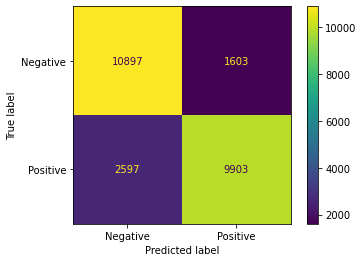

In [141]:
# lemmas, no stop words, subj. classifier trained on entire dataset. unigram WHOLE IMDb DATASET

              precision    recall  f1-score   support

    Negative       0.73      0.85      0.78       497
    Positive       0.82      0.68      0.74       503

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.76      1000
weighted avg       0.77      0.77      0.76      1000

Accuracy: 765/1000=0.765


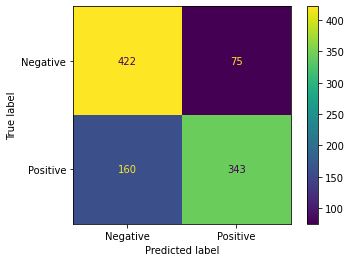

In [116]:
# lemmas, no stop words, subj. classifier trained on entire dataset. bigram PARTIAL IMDb DATASET

              precision    recall  f1-score   support

    Negative       0.73      0.85      0.78       497
    Positive       0.82      0.68      0.74       503

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.76      1000
weighted avg       0.77      0.77      0.76      1000

Accuracy: 765/1000=0.765


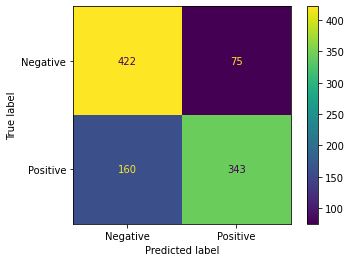

In [111]:
# lemmas, no stop words, subj. classifier trained on entire dataset. unigram PARTIAL IMDb DATASET

              precision    recall  f1-score   support

    Negative       0.77      0.65      0.70       492
    Positive       0.70      0.81      0.75       508

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000

accuracy: 730/1000=0.73


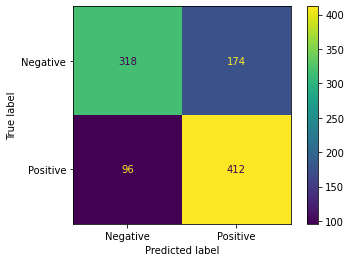

In [96]:
# lemmas, no stop words, no subj. classifier. binary classes of RT data, PARTIAL RT DATASET

               precision    recall  f1-score   support

Very Negative       0.55      0.02      0.04       259
     Negative       0.40      0.59      0.48       566
      Neutral       0.25      0.07      0.10       350
     Positive       0.31      0.67      0.42       463
Very Positive       0.51      0.08      0.13       362

     accuracy                           0.35      2000
    macro avg       0.40      0.29      0.24      2000
 weighted avg       0.39      0.35      0.28      2000



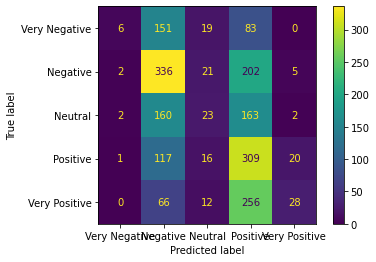

In [45]:
# lemmas, no stop words, no subj. classifier. PARTIAL RT DATASET

In [37]:
# Save data
#df_tr_filtered.to_csv('imdb_maas_train_subj_filtered.csv')
#df_te_filtered.to_csv('imdb_maas_test_subj_filtered.csv')